In [1]:
import os
os.chdir("../..")
print(os.getcwd())

C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\MS2LDA


## Load spectra, Clean spectra and generate a Corpus for LDA

In [2]:
from Preprocessing.load_and_clean import load_mgf
from Preprocessing.load_and_clean import clean_spectra

from Preprocessing.generate_corpus import features_to_words
from Preprocessing.generate_corpus import combine_features

In [3]:
# define spectra path, change from \\ to / for mac
#spectra_path = "test_data/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf"
#spectra_path = "test_data/pos_ache_inhibitors_pesticides.mgf"
spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\MEDUSA\notebooks\MS2LDA\PDE5_standards_annotated_pos_unique.mgf"

In [4]:
# This is the cleaning part: removing spectra with too less peaks and so on ...
spectra = load_mgf(spectra_path)
cleaned_spectra = clean_spectra(spectra)

In [5]:
len(cleaned_spectra)

23

In [6]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage

In [7]:
cleaned_spectra[0].metadata

{'charge': 1,
 'feature_id': '258',
 'adduct': '[M+H]+',
 'scans': '258',
 'num_peaks': '18',
 'smiles': 'O=C1OC(C2=C1C=CC=C2)(C3=CC=C(C=C3)O[H])C4=CC=C(C=C4)O[H]',
 'compound_name': 'Phenolphthalein',
 'ms_level': '2',
 'retention_time': 553.47,
 'precursor_mz': 319.09666,
 'ionmode': 'positive',
 'spectrum_nr': '830',
 'retention_index': None}

In [8]:
smiles = []
names = []
for spec in cleaned_spectra:
    smiles.append(spec.get("smiles"))
    names.append(spec.get("compound_name"))

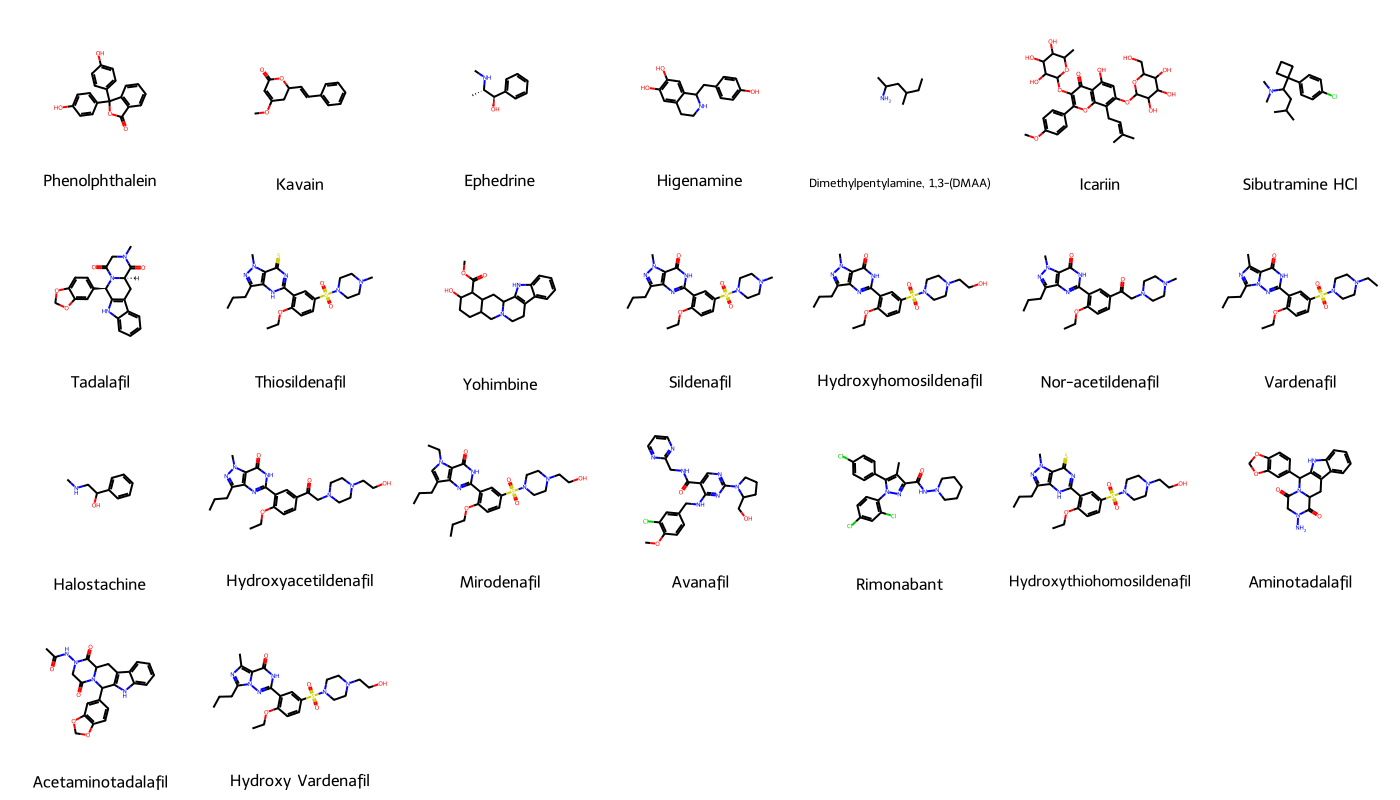

In [9]:
MolsToGridImage([MolFromSmiles(smi) for smi in smiles], molsPerRow=7, legends=names)

In [10]:
# This is the Corpus generatino part: adding frag@ and loss@ and so on ...
fragment_words, loss_words = features_to_words(cleaned_spectra)
feature_words = combine_features(fragment_words, loss_words)

## Topic Modelling

In [11]:
from MS2LDA.modeling import define_model
from MS2LDA.modeling import train_model
from MS2LDA.modeling import extract_motifs
from MS2LDA.modeling import create_motif_spectra

In [12]:
# set the model parameters. Number of motifs must be given, the rest can be based on tomotopy implementation: https://bab2min.github.io/tomotopy/v0.12.6/en/#tomotopy.LDAModel
model_parameters = {
    "rm_top": 0,
    "min_cf": 0,
    "min_df": 0,
    "alpha": 0.1,
    "eta": 0.1,
    "seed": 42,
}
ms2lda = define_model(n_motifs=15, model_parameters=model_parameters)

In [13]:
%%time
# set the training parameters based on the tomotopy implementation: https://bab2min.github.io/tomotopy/v0.12.6/en/#tomotopy.LDAModel.train
# the parallization scheme (keyword parallel) has a big impact on the speed.
train_parameters = {"parallel": 3}
trained_ms2lda = train_model(ms2lda, feature_words, iterations=100, train_parameters=train_parameters)

CPU times: total: 422 ms
Wall time: 130 ms


C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\MS2LDA\MS2LDA\modeling.py:39: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(iterations, **train_parameters)


In [14]:
# retrieves motif from LDA model and converts it into a matchms spectrum object
motifs = extract_motifs(trained_ms2lda, top_n=20)
motif_spectra = create_motif_spectra(motifs)

## Annotate Topics

In [15]:
from Add_On.Spec2Vec.annotation import load_s2v_and_library
from Add_On.Spec2Vec.annotation import calc_embeddings, calc_similarity
from Add_On.Spec2Vec.annotation import get_library_matches

In [16]:
%%time
path_model = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\MS2LDA\Add_On\Spec2Vec\model\020724_Spec2Vec_CleanedLibraries.model"
path_library = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\MS2LDA\Add_On\Spec2Vec\model\new_library.pkl" 
s2v_similarity, library = load_s2v_and_library(path_model, path_library)

CPU times: total: 19.6 s
Wall time: 20 s


In [17]:
%%time
# calculate embeddings for found motifs
motif_embeddings = calc_embeddings(s2v_similarity, motif_spectra)

CPU times: total: 0 ns
Wall time: 4 ms


In [18]:
%%time
# calculate similarity between found motifs and GNPS library with Spec2Vec
similarity_matrix = calc_similarity(motif_embeddings, library.embeddings)

CPU times: total: 31.2 s
Wall time: 26.3 s


In [19]:
%%time
matching_settings = {
    "similarity_matrix": similarity_matrix,
    "library": library,
    "top_n": 5,
    "unique_mols": True
}
library_matches = get_library_matches(matching_settings)

CPU times: total: 453 ms
Wall time: 475 ms


### Refined Annotations

In [20]:
from Add_On.Spec2Vec.annotation_refined import mask_spectra
from Add_On.Spec2Vec.annotation_refined import refine_annotation

In [21]:
masked_motif_spectra = mask_spectra(motif_spectra)

In [22]:
optimized_motif_spectra, optimized_clusters, smiles_clusters = refine_annotation(s2v_similarity, library_matches, masked_motif_spectra, motif_spectra)

Not Enough Spectra Match!
Similarity Match:  0.9685950413223141
Similarity Match:  0.986266094420601
Only one cluster:  0.5004291845493564
Similarity Match:  0.7424892703862662
Similarity Match:  0.7407725321888413
Not Enough Spectra Match!
Similarity Match:  0.7315315315315315
Only one cluster:  0.24077046548956654
Not Enough Spectra Match!
Similarity Match:  0.7032967032967031
Similarity Match:  0.7853281853281852
Not Enough Spectra Match!
Similarity Match:  0.7945425361155696
Similarity Match:  0.831404958677686


In [23]:
#from rdkit.Chem import MolFromSmiles
#from rdkit.Chem.Draw import MolsToGridImage

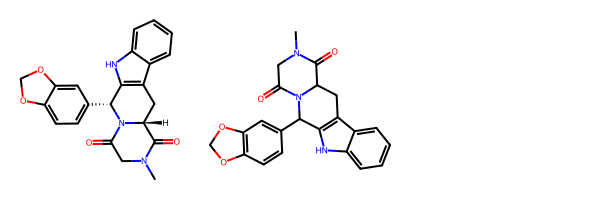

In [40]:
i = 2
MolsToGridImage([MolFromSmiles(smiles) for smiles in smiles_clusters[i]])

[135.04 169.08 205.09 232.08 233.08 250.09 262.09 268.11]
[]


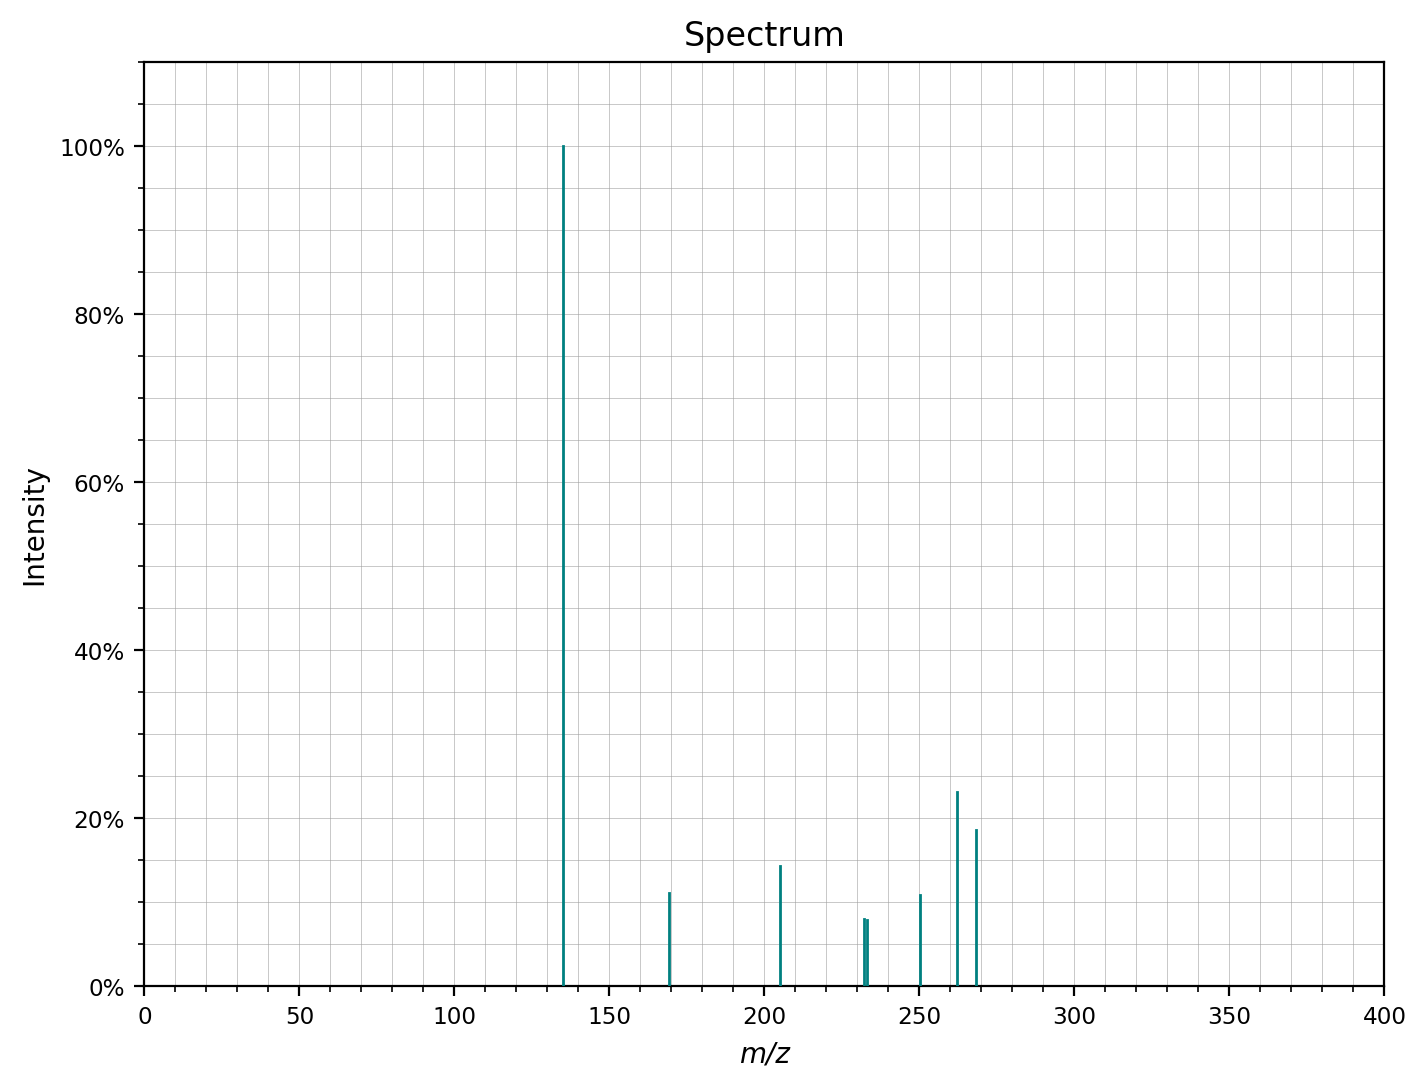

In [41]:
optimized_motif_spectra[i].plot()
print(optimized_motif_spectra[i].peaks.mz)
print(optimized_motif_spectra[i].losses.mz)

[135.04 169.08 204.08 205.09 232.08 233.08 250.09 262.09 263.09 268.11]
[150.03 184.05 201.07 220.08 235.48 243.38 255.11 275.09 285.11 311.09]


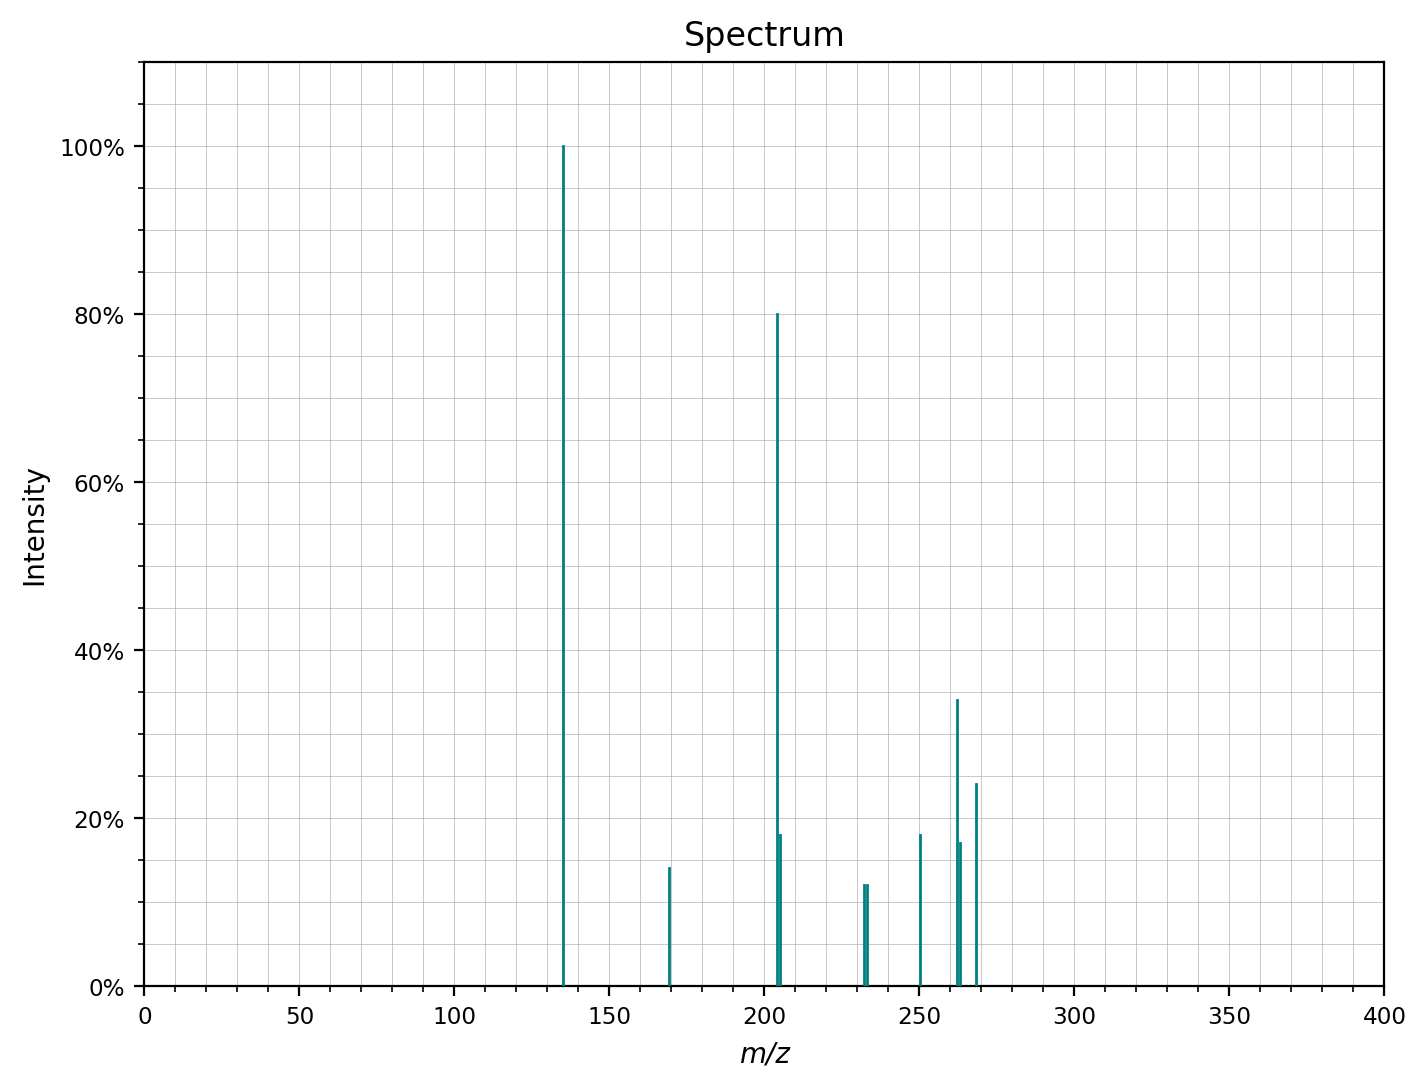

In [42]:
motif_spectra[i].plot()
print(motif_spectra[i].peaks.mz)
print(motif_spectra[i].losses.mz)

[135.04 169.08 205.09 232.08 233.08 250.09 262.09 268.11]
[311.09]

### Motif Fingerprints 

In [36]:
from Add_On.Fingerprints.FP_annotation import annotate_motifs
from Add_On.Fingerprints.FP_annotation import smiles2mols, mols2fps, scale_fps, fps2motif
from Add_On.Fingerprints.FP_calculation.rdkit_fps import calc_MACCS

In [37]:
mols = [smiles2mols(info[0]) for info in library_matches]

In [38]:
fps = [calc_MACCS(mol) for mol in mols]

[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS
[FP]: Executing calc_MACCS


In [39]:
scaled_fps = [scale_fps(fp) for fp in fps]

In [40]:
motif_fps = [fps2motif(scaled_fp, 0.60) for scaled_fp in scaled_fps]

### Property Prediction

In [41]:
import joblib
from scipy.stats import pearsonr, spearmanr
import numpy as np

In [42]:
molLogP_rf = joblib.load("notebooks/MyStuff/molLogP_model.pkl")
tox24_rf = joblib.load("notebooks/MyStuff/Tox24_model.pkl")

In [43]:
motif_preds = tox24_rf.predict(motif_fps) # model here

In [44]:
molLogPs_preds = []
for mols_per_motif in fps:
    molLogPs_per_motif = []
    for mol in mols_per_motif:
        molLogP = tox24_rf.predict([mol]) # model here
        molLogPs_per_motif.append(molLogP)
    average_molLogP = np.sum(molLogPs_per_motif)/len(molLogPs_per_motif)
    molLogPs_preds.append(average_molLogP)

In [45]:
pearsonr(molLogPs_preds, motif_preds)

PearsonRResult(statistic=0.7815967139808004, pvalue=0.0005782333925230983)

In [46]:
spearmanr(molLogPs_preds, motif_preds)

SignificanceResult(statistic=0.8428571428571429, pvalue=7.967195252724858e-05)

#### Testing the accuracy

In [94]:
from rdkit.Chem.Crippen import MolLogP

In [95]:
molLogPs = [] # only log P
for mols_per_motif in mols:
    molLogPs_per_motif = []
    for mol in mols_per_motif:
        molLogP = MolLogP(mol)
        molLogPs_per_motif.append(molLogP)
    average_molLogP = np.sum(molLogPs_per_motif)/len(molLogPs_per_motif)
    molLogPs.append(average_molLogP)

In [97]:
pearsonr(molLogPs, motif_preds)

PearsonRResult(statistic=0.6758981558559924, pvalue=2.174309669786714e-41)

In [98]:
spearmanr(molLogPs, motif_preds)

SignificanceResult(statistic=0.6709136107670258, pvalue=1.3657578879969364e-40)

In [120]:
molLogPs_preds = []
for mols_per_motif in fps:
    molLogPs_per_motif = []
    for mol in mols_per_motif:
        molLogP = tox24_rf.predict([mol]) # model here
        molLogPs_per_motif.append(molLogP)
    average_molLogP = np.sum(molLogPs_per_motif)/len(molLogPs_per_motif)
    molLogPs_preds.append(average_molLogP)

In [100]:
pearsonr(molLogPs, molLogPs_preds)

PearsonRResult(statistic=0.8166745589098486, pvalue=4.0195710053835617e-73)

In [101]:
spearmanr(molLogPs, molLogPs_preds)

SignificanceResult(statistic=0.8308976766408516, pvalue=7.507698131232384e-78)

---

### Screening

In [43]:
import ms_entropy as me

In [44]:
from Add_On.NTS.Screening import run_screen

In [55]:
spectra_to_screen = load_mgf(r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Raw2Spec\20231215_PDE-5\20231215_MZMLdata_LC_OTT4\pos\mzmine403_231212_sildenafil_pos_LC-OTT4_SC_sirius.mgf")

In [56]:
%%time
cleaned_spectra_to_screen = clean_spectra(spectra_to_screen)

CPU times: total: 58.4 s
Wall time: 58.7 s


In [57]:
noisefree_spectra_to_screen = []
for spec in cleaned_spectra_to_screen:
    if spec:
        entropy = me.calculate_spectral_entropy(list(zip(spec.peaks.mz, spec.peaks.intensities)), clean_spectrum = True, min_ms2_difference_in_da = 0.05)
        if entropy < 3:
            noisefree_spectra_to_screen.append(spec)

In [58]:
len(cleaned_spectra_to_screen), len(noisefree_spectra_to_screen)

(11073, 10586)

In [59]:
%%time
A,B,C,D = run_screen(optimized_motif_spectra[i], noisefree_spectra_to_screen)

CPU times: total: 2.92 s
Wall time: 2.93 s


In [117]:
c = 0
p_mz_old = 0.
for z, a in enumerate(A):
    p_mz = noisefree_spectra_to_screen[a].get("precursor_mz")
    #print(round(p_mz, 3), round(p_mz_old, 3))
    #print(round(p_mz, 3) ==  round(p_mz_old, 3))
    if round(p_mz, 3) == round(p_mz_old, 3):
        pass
    else:
        p_mz_old = p_mz
        c += 1
    print(c, z, p_mz)

1 0 376.12967
1 1 376.12965
1 2 376.12965
1 3 376.12965
2 4 376.29778
3 5 377.13174
3 6 377.13174
3 7 377.13174
4 8 378.13464
5 9 379.13766
5 10 379.13766
6 11 390.14528
6 12 390.14528
7 13 404.16089
8 14 415.19179
9 15 418.17627
9 16 418.17642
10 17 420.15561
11 18 427.10558
11 19 427.10562
12 20 429.10269
13 21 433.18755
14 22 434.17128
14 23 434.17128
14 24 434.17136
14 25 434.17117
15 26 435.17355
16 27 436.17646
17 28 447.20288
18 29 461.0671


461.0671
[135.043625 204.080383 205.08844  216.080521 233.082245 262.086853
 263.092957 274.086182 334.107391]
[126.959709 186.980918 197.974143 198.980247 227.984855 244.986579
 255.97866  256.986717 326.023475]
{'feature_id': '10339', 'charge': 1, 'scans': '10339', 'num_peaks': '9', 'ms_level': '2', 'retention_time': 713.21, 'precursor_mz': 461.0671, 'ionmode': 'positive', 'retention_index': None}


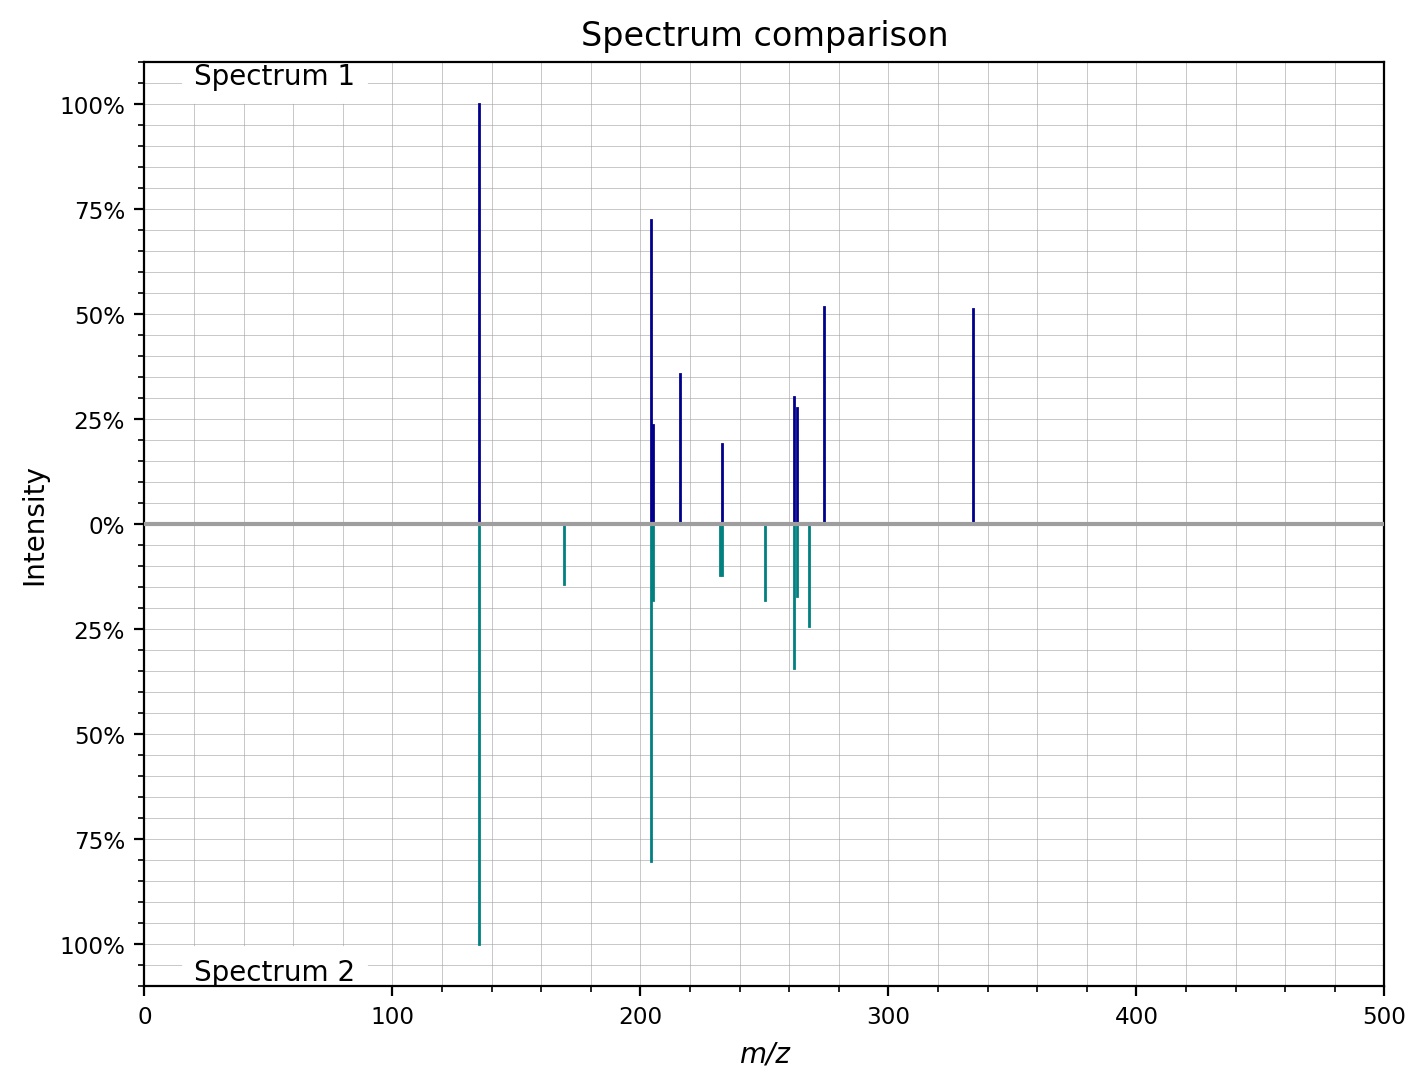

In [129]:
l = 29
#noisefree_spectra_to_screen[A[l]].plot_against(optimized_motif_spectra[i])
##noisefree_spectra_to_screen[A[l]].plot_against(noisefree_spectra_to_screen[A[l+1]])
noisefree_spectra_to_screen[A[l]].plot_against(motif_spectra[i])
print(noisefree_spectra_to_screen[A[l]].get("precursor_mz"))
print(noisefree_spectra_to_screen[A[l]].peaks.mz)
print(noisefree_spectra_to_screen[A[l]].losses.mz)
print(noisefree_spectra_to_screen[A[l]].metadata)

In [91]:
print(noisefree_spectra_to_screen[A[l]].metadata)

{'feature_id': '7959', 'charge': 1, 'scans': '7959', 'num_peaks': '11', 'ms_level': '2', 'retention_time': 612.7, 'precursor_mz': 434.17128, 'ionmode': 'positive', 'retention_index': None}


In [92]:
aa = A[l]

In [93]:
from ms2query.ms2library import create_library_object_from_one_dir
from ms2query.utils import SettingsRunMS2Query

In [94]:
ms2query_library = create_library_object_from_one_dir(r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SimilaritySearch\scripts\ms2query_library_files\positive_mode")
analogs = ms2query_library.analog_search_yield_df([noisefree_spectra_to_screen[aa]], progress_bar=True)

In [95]:
analogs = list(analogs)

Predicting matches for query spectra: 100%|██████████████████████████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


In [96]:
analogs[0].analog_compound_name.to_list()

['1-cyclohexyl-2-[(2-methoxy-5-(1,2,3,4-tetrahydrobeta-carbolinyl)phenyl)methoxy ]benzene, acetic acid']

In [97]:
analogs

[   query_spectrum_nr  ms2query_model_prediction  precursor_mz_difference  \
 0                  1                   0.577926                 33.09772   
 
    precursor_mz_query_spectrum  precursor_mz_analog        inchikey  \
 0                    434.17128              467.269  FIQQLJZRRJZKJB   
 
                                 analog_compound_name  \
 0  1-cyclohexyl-2-[(2-methoxy-5-(1,2,3,4-tetrahyd...   
 
                                               smiles  retention_time  \
 0  COc1ccc(C2NCCc3c2[nH]c2ccccc32)cc1COc1ccccc1C1...           612.7   
 
   retention_index         cf_kingdom              cf_superclass  \
 0            None  Organic compounds  Alkaloids and derivatives   
 
             cf_class cf_subclass   cf_direct_parent    npc_class_results  \
 0  Harmala alkaloids              Harmala alkaloids  Carboline alkaloids   
 
   npc_superclass_results npc_pathway_results  
 0   Tryptophan alkaloids           Alkaloids  ]

In [98]:
analogs[0].smiles.to_list()

['COc1ccc(C2NCCc3c2[nH]c2ccccc32)cc1COc1ccccc1C1CCCCC1']